# HackThisAI: medium_flying_pig

In [1]:
import matplotlib.pyplot as plt
import os
import subprocess
import time
from PIL import Image
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.models import resnet50

In [2]:
%%capture
!docker build --tag flying_pigs challenge/medium_flying_pigs/

In [3]:
%%capture
subprocess.call("docker run -p 5000:5000 flying_pigs:latest &", shell=True)

In [4]:
print("Waiting to make sure container starts.")
time.sleep(10)

Waiting to make sure container starts.


[2021-12-22 20:46:06 +0000] [1] [INFO] Starting gunicorn 20.1.0
[2021-12-22 20:46:06 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2021-12-22 20:46:06 +0000] [1] [INFO] Using worker: sync
[2021-12-22 20:46:06 +0000] [9] [INFO] Booting worker with pid: 9
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 18.2MB/s]

We want to submit a mask, that when added to the provided pig picture, gets the pig classified as an airliner.

In [5]:
def get_tensor_from_img(img_path):
    img = Image.open(img_path)
    preprocess = transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()])
    return preprocess(img)[None, :, :, :]

src_dir = "challenge/medium_flying_pig/"

Let's start with some naive solutions. What happens if we just submit an airliner? Let's go to google images and find one.

![airliner.jpg](challenge/medium_flying_pig/airliner.jpg)

I chose this specific plane because it had several features that I thought might be important to the classifier including being able to see both wings, being able to see the tail, and being able to see the jet engines.

In [6]:
plane = get_tensor_from_img(src_dir+"airliner.jpg")
save_image(plane, src_dir+"plane.jpg")

So now we have a plane resized and transformed to be a suitable mask for the pig. What is this amalgamation going to look like to the classifier?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


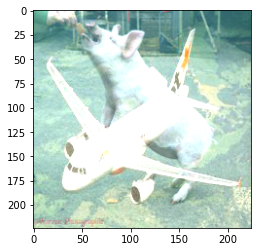

In [7]:
pig_plane = get_tensor_from_img(src_dir+"pig.jpg") + get_tensor_from_img(src_dir+"plane.jpg")
plt.imshow(pig_plane[0].numpy().transpose(1,2,0))
torch.save(pig_plane, src_dir+"pig_plane.pt")

Notice the clipping warning. We didn't even check to make sure that values remained in the expected range for colors `[0:255]`. I think we should submit it anyway.

In [8]:
def submit(path):
    with open(path, "rb") as f:
        r = requests.post("http://localhost:5000/check", files={"data_file": f})
    return r.text

submit(src_dir+"pig_plane.pt")

"You're still stuck in the mud"

Okay, that didn't work. Remember, we were supposed to submit a mask. The image we see above isn't what's getting submitted to the classifier. It's getting added to the original pig image first. What if we take our plane image and subtract the pig. We know exactly what pig image they're using.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


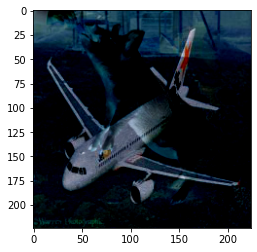

In [9]:
plane_minus_pig = get_tensor_from_img(src_dir+"plane.jpg") - get_tensor_from_img(src_dir+"pig.jpg")
plt.imshow(plane_minus_pig[0].numpy().transpose(1,2,0))
torch.save(plane_minus_pig, src_dir+"plane_minus_pig.pt")

Again, we didn't bother dealing with colors out of the expected bounds, but we see the negative pig and our positive plane. It's almost art. Let's submit that.

In [10]:
submit(src_dir+"plane_minus_pig.pt")

'Your pig can fly! FLAG{RADIANT}'

## BONUS

Nice! But as we can see above, that wouldn't fool a human. It _really_ won't fool a human once we add the positive pig back in... it's just a plane. In most adversarial ML discussions, we're really interested in the _minimal_ adversarial examples. Using our own pretrained resnet, let's build an offline example and a minimal adversarial example using this guide: https://adversarial-ml-tutorial.org/introduction/

In [11]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]


norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [12]:
%%capture
model = resnet50(pretrained=True)
model.eval()

In [13]:
pig = get_tensor_from_img(src_dir+"pig.jpg")
delta = torch.zeros_like(pig, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)
epsilon = 2./255

for t in range(100):
    pred = model(norm(pig + delta))
    # 341 corresponds to hog, 404 to airliner
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

In [14]:
torch.save(delta, src_dir+"delta.pt")

Let's save `delta` and submit it.

In [15]:
submit(src_dir+"delta.pt")

'Your pig can fly! FLAG{RADIANT}'

As we can see below, we've really made _very_ little change to the image.

In [16]:
delta.mean()

tensor(2.2753e-05, grad_fn=<MeanBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


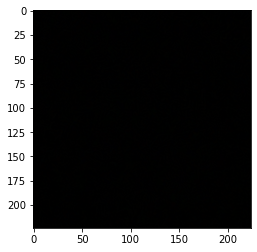

In [17]:
plt.imshow(delta[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MODIFIED


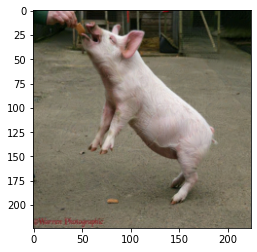

In [18]:
print("MODIFIED")
plt.imshow((pig+delta)[0].detach().numpy().transpose(1,2,0))

ORIGINAL


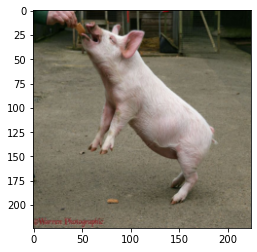

In [19]:
print("ORIGINAL")
plt.imshow((pig)[0].detach().numpy().transpose(1,2,0))